In [1]:
from network import * 
import math
from typing import Any

import torch
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import Module, init
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms

device = torch.device("mps")


In [2]:
def plot_result(result_dict):
    losses = result_dict['losses']
    accuracies = result_dict['accuracies']
    models = result_dict['models']

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for m in models:
        plt.plot(losses[m], label="training loss "+ m)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    for m in models:
        plt.plot(accuracies[m], label="val acc "+ m)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
def train_models(seed, 
                M = 3,  
                H = 20, 
                in_dim = 28, 
                out_dim = 10, 
                num_epochs = 20,
                verbose = True):
    '''
    INPUTs:
        seed: int, 
            manual seeds for initialization
        M: int, 
            specifying number of parallel synapses
        save: bool = False, 
            whether to save the model
    OUTPUTs:
        
    '''
    torch.manual_seed(seed)
    models = {
        '1-NN':  SingleNeuron(in_dim * in_dim, out_dim), \
        '1-NN with parallel synapse':  ParallelSynapseNeuron(in_dim * in_dim, M, out_dim), \
        
        '2-NN (H={:d})'.format(H):  TwoLayerNN(in_dim * in_dim, H, out_dim), \
        
        '2-NN with parallel synapse (M={:d}) at hidden layer (H={:d})'.format(M, H):  ParallelSynapseNN1(in_dim * in_dim, M, H, out_dim),\
        # '2-NN with parallel synapse (M={:d}) at input layer (H={:d})'.format(M, H):  ParallelSynapseNN2(in_dim * in_dim, M, H, out_dim)
        }
    accuracies = {}
    losses = {}
    for m in models:
        accuracies[m] = []
        losses[m] = []
            
    # Load the MNIST dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
    
    for model_name in models:
        model = models[model_name]
        # Initialize model, criterion, and optimizer 
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        for epoch in range(num_epochs):
            # Training loop
            if 'parallel synapse' in model_name:
                with torch.no_grad():
                    model.parallel_synapse.thres.data = torch.clamp(model.parallel_synapse.thres.data, -1.5, 1.5)
                
            model.train()
            running_loss = 0.0
            for i, (inputs, labels) in enumerate(trainloader):
                inputs = inputs.view(-1, 28*28).to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = F.nll_loss(outputs, labels) 
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            losses[model_name].append(running_loss / len(trainloader))
            # Validation loop for accuracy
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs = inputs.view(-1, 28*28).to(device)
                    labels = labels.to(device)
                    
                    outputs = model(inputs)
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

            accuracy = 100 * correct / total 
            accuracies[model_name].append(accuracy)
            if verbose and epoch % 10 == 0:
                print(model_name + f" Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {accuracy:.2f}%")
    
    return {'seed': seed, 
            'M': M,
            'models': models,
            'accuracies': accuracies,
            'losses': losses
            }

1-NN Epoch 1/41, Loss: 0.4294, Accuracy: 90.86%
1-NN Epoch 11/41, Loss: 0.2852, Accuracy: 91.71%
1-NN Epoch 21/41, Loss: 0.2757, Accuracy: 92.35%
1-NN Epoch 31/41, Loss: 0.2677, Accuracy: 92.02%
1-NN Epoch 41/41, Loss: 0.2660, Accuracy: 91.64%
1-NN with parallel synapse Epoch 1/41, Loss: 0.7457, Accuracy: 89.24%
1-NN with parallel synapse Epoch 11/41, Loss: 0.2772, Accuracy: 91.80%
1-NN with parallel synapse Epoch 21/41, Loss: 0.2558, Accuracy: 92.51%
1-NN with parallel synapse Epoch 31/41, Loss: 0.2441, Accuracy: 92.39%
1-NN with parallel synapse Epoch 41/41, Loss: 0.2333, Accuracy: 92.45%
2-NN (H=20) Epoch 1/41, Loss: 0.5323, Accuracy: 90.11%
2-NN (H=20) Epoch 11/41, Loss: 0.2571, Accuracy: 92.38%
2-NN (H=20) Epoch 21/41, Loss: 0.2329, Accuracy: 92.64%
2-NN (H=20) Epoch 31/41, Loss: 0.2229, Accuracy: 92.91%
2-NN (H=20) Epoch 41/41, Loss: 0.2146, Accuracy: 92.91%
2-NN with parallel synapse (M=3) at hidden layer (H=20) Epoch 1/41, Loss: 0.5306, Accuracy: 92.11%
2-NN with parallel synap

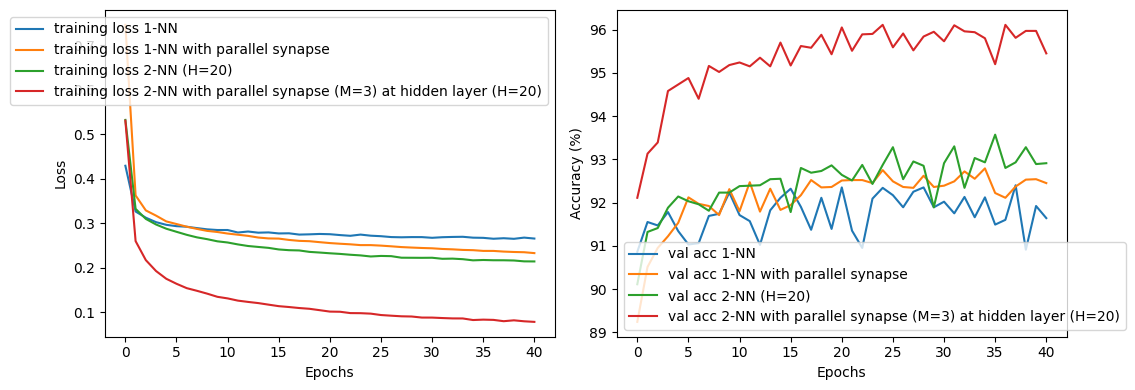

1-NN Epoch 1/41, Loss: 0.4268, Accuracy: 90.92%
1-NN Epoch 11/41, Loss: 0.2826, Accuracy: 91.92%
1-NN Epoch 21/41, Loss: 0.2743, Accuracy: 91.49%
1-NN Epoch 31/41, Loss: 0.2692, Accuracy: 92.22%
1-NN Epoch 41/41, Loss: 0.2669, Accuracy: 91.77%
1-NN with parallel synapse Epoch 1/41, Loss: 0.7513, Accuracy: 89.49%
1-NN with parallel synapse Epoch 11/41, Loss: 0.2777, Accuracy: 92.14%
1-NN with parallel synapse Epoch 21/41, Loss: 0.2567, Accuracy: 92.22%
1-NN with parallel synapse Epoch 31/41, Loss: 0.2454, Accuracy: 92.85%
1-NN with parallel synapse Epoch 41/41, Loss: 0.2356, Accuracy: 92.76%
2-NN (H=20) Epoch 1/41, Loss: 0.5499, Accuracy: 88.82%
2-NN (H=20) Epoch 11/41, Loss: 0.2666, Accuracy: 92.26%
2-NN (H=20) Epoch 21/41, Loss: 0.2479, Accuracy: 92.43%
2-NN (H=20) Epoch 31/41, Loss: 0.2364, Accuracy: 92.70%
2-NN (H=20) Epoch 41/41, Loss: 0.2294, Accuracy: 92.07%
2-NN with parallel synapse (M=3) at hidden layer (H=20) Epoch 1/41, Loss: 0.5221, Accuracy: 91.57%
2-NN with parallel synap

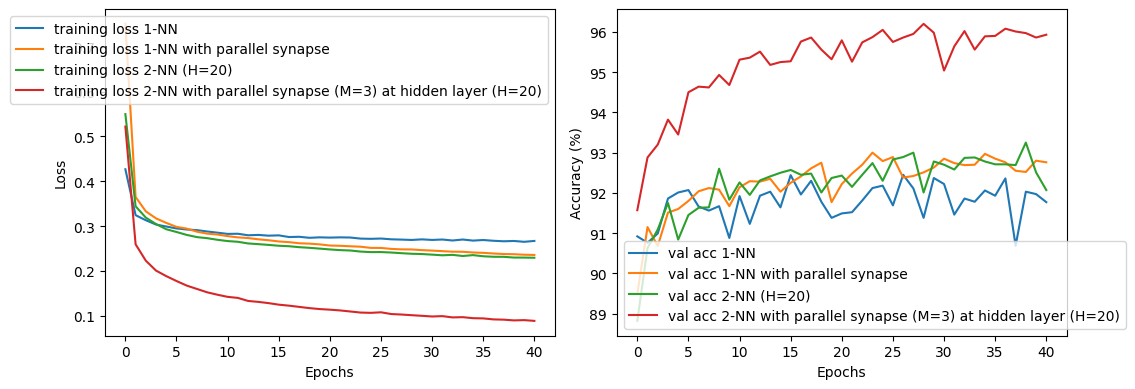

1-NN Epoch 1/41, Loss: 0.4254, Accuracy: 90.17%
1-NN Epoch 11/41, Loss: 0.2837, Accuracy: 91.36%
1-NN Epoch 21/41, Loss: 0.2749, Accuracy: 91.61%
1-NN Epoch 31/41, Loss: 0.2699, Accuracy: 92.11%
1-NN Epoch 41/41, Loss: 0.2644, Accuracy: 91.96%
1-NN with parallel synapse Epoch 1/41, Loss: 0.7314, Accuracy: 89.59%
1-NN with parallel synapse Epoch 11/41, Loss: 0.2768, Accuracy: 92.45%
1-NN with parallel synapse Epoch 21/41, Loss: 0.2563, Accuracy: 92.51%
1-NN with parallel synapse Epoch 31/41, Loss: 0.2449, Accuracy: 92.71%
1-NN with parallel synapse Epoch 41/41, Loss: 0.2344, Accuracy: 92.65%
2-NN (H=20) Epoch 1/41, Loss: 0.5954, Accuracy: 88.70%
2-NN (H=20) Epoch 11/41, Loss: 0.2928, Accuracy: 91.00%
2-NN (H=20) Epoch 21/41, Loss: 0.2714, Accuracy: 92.08%
2-NN (H=20) Epoch 31/41, Loss: 0.2575, Accuracy: 92.03%
2-NN (H=20) Epoch 41/41, Loss: 0.2535, Accuracy: 92.35%
2-NN with parallel synapse (M=3) at hidden layer (H=20) Epoch 1/41, Loss: 0.5356, Accuracy: 91.41%
2-NN with parallel synap

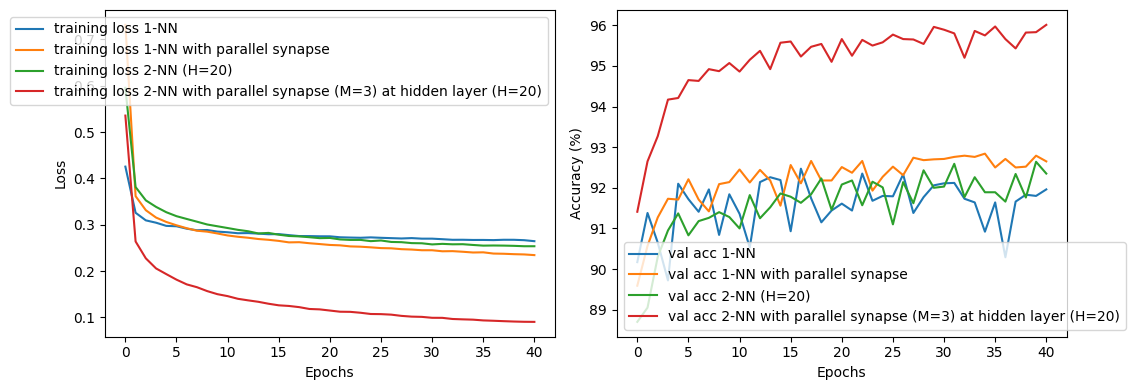

1-NN Epoch 1/41, Loss: 0.4312, Accuracy: 90.99%


In [4]:
import pickle
import pandas as pd
experiment = []

for i in range(5):
    result_dict = train_models(i, num_epochs = 81)
    experiment.append(result_dict)
    plot_result(result_dict)

    df = pd.DataFrame(experiment)
    with open('./data/MNIST_result.pkl', 'wb') as f:
        pickle.dump(df, f)

1


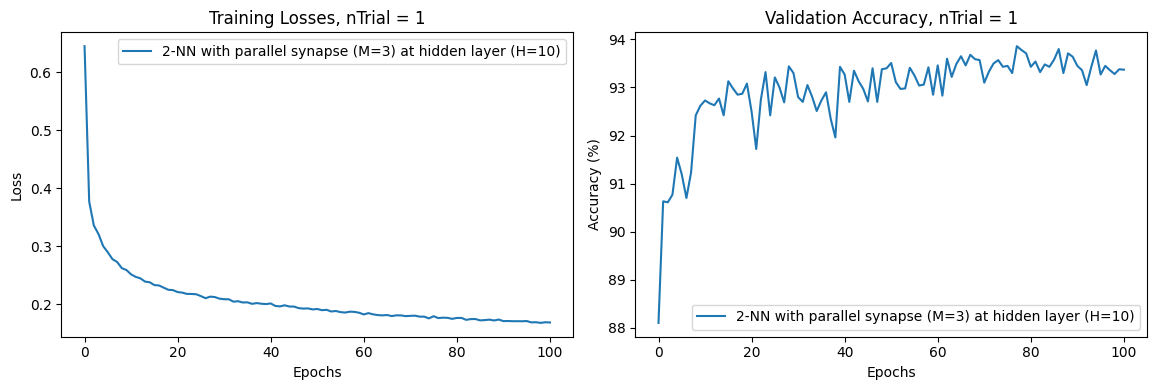

In [2]:
import pandas as pd
for H in [10]:
    df = pd.read_pickle('./data/MNIST_result_H={:d}_M=3_.pkl'.format(H))
    print(len(df))
    accuracies = {}
    losses = {}
    for model in df['models'][0].keys():
        accuracies[model] = np.array([df['accuracies'][i][model] for i in range(len(df))])
        losses[model] = np.array([df['losses'][i][model] for i in range(len(df))])
        
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for model in df['models'][0].keys():
        plt.plot(losses[model].mean(axis=0), label=model)
        plt.fill_between(range(len(losses[model].mean(axis=0))), losses[model].mean(axis=0) - losses[model].std(
            axis=0)/np.sqrt(len(df)), losses[model].mean(axis=0) + losses[model].std(axis=0)/np.sqrt(len(df)), alpha=0.3)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Losses, nTrial = {:d}".format(len(df)))
    plt.legend()

    plt.subplot(1, 2, 2)
    for model in df['models'][0].keys():
        plt.plot(accuracies[model].mean(axis=0), label=model)
        plt.fill_between(range(len(accuracies[model].mean(axis=0))), accuracies[model].mean(axis=0) - accuracies[model].std(
            axis=0)/np.sqrt(len(df)), accuracies[model].mean(axis=0) + accuracies[model].std(axis=0)/np.sqrt(len(df)), alpha=0.3)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy, nTrial = {:d}".format(len(df)))
    plt.legend()
    plt.tight_layout()

In [110]:
df

,seed,M,models,accuracies,losses
0,0,3,{'2-NN with parallel synapse (M=3) at hidden l...,{'2-NN with parallel synapse (M=3) at hidden l...,{'2-NN with parallel synapse (M=3) at hidden l...


In [99]:
df.models[0]['2-NN with parallel synapse (M=3) at hidden layer (H=5)'].parallel_synapse.thres.data

tensor([[ 1.6994e-01,  2.9619e-01, -1.2841e-02,  1.7442e-01,  1.3505e+00],
        [ 1.4930e+00,  1.2207e-02,  9.9226e-01,  6.1860e-01,  8.6316e-02],
        [ 1.0223e-01,  8.2511e-01,  1.3122e+00,  2.2445e-01, -2.2277e-04]])

(array([51., 18.,  6.,  5., 12., 15.,  8.,  9., 15.,  9.,  5., 15.,  8.,
         6.,  4.,  9., 10., 30., 61.,  4.]),
 array([-0.05199014,  0.00594952,  0.06388919,  0.12182885,  0.17976852,
         0.23770818,  0.29564786,  0.35358751,  0.41152719,  0.46946687,
         0.52740651,  0.58534616,  0.64328587,  0.70122552,  0.75916517,
         0.81710488,  0.87504452,  0.93298417,  0.99092382,  1.04886353,
         1.10680318]),
 <BarContainer object of 20 artists>)

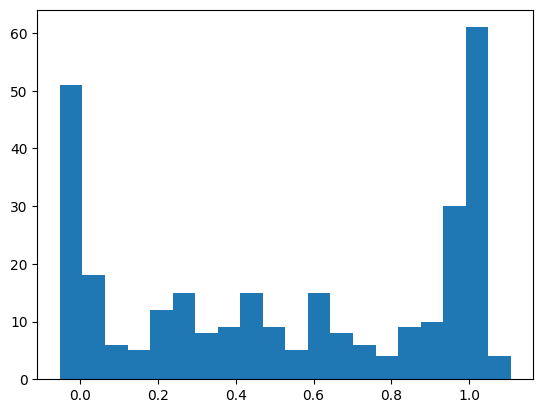

In [10]:
# Plot aggregate synaptic function of parallel synapses
plt.hist(df.models[0]['2-NN with parallel synapse (M=3) at hidden layer (H=10)'].parallel_synapse.ampli.data.cpu().numpy().flatten(), bins=20)


In [5]:
input = torch.linspace(0, 1, 100).view(-1,1).repeat(1, 10) # 

f = df.models[0]['2-NN with parallel synapse (M=3) at hidden layer (H=10)'].parallel_synapse

In [92]:
f(input).shape

torch.Size([100, 5])

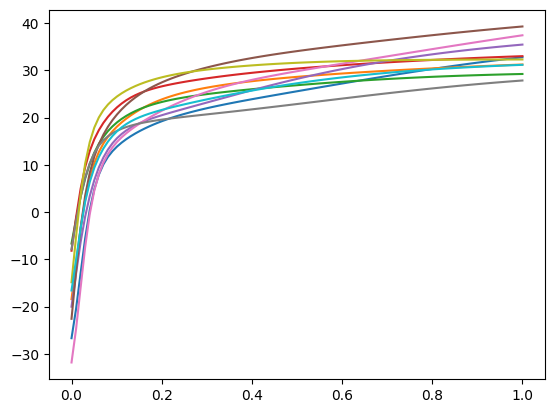

In [6]:
plt.plot(input[:,0].numpy(), f(input).detach().numpy())

In [94]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)



In [95]:
f1 =  df.models[0]['2-NN with parallel synapse (M=3) at hidden layer (H=5)'].fc1
for i, (inputs, labels) in enumerate(trainloader):
    output1 = f1(inputs.view(-1, 28*28))
    output2 = torch.relu(output1)
    output3 = f(output2)
    break

(array([ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 19.,
         0.,  0.,  0.,  0., 27.,  1.,  0.,  0., 19.,  0.,  1.,  0., 23.,
         0.,  2.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         0.,  3.,  3.,  2.,  1.,  0.,  1.,  1.,  2.,  2.,  2.,  1.,  1.,
         2.,  1.,  0.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  2.,
         0.,  3.,  1.,  2.,  0.,  2.,  3.,  1.,  1.,  0.,  0.,  1.,  0.,
         1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([2.20658159, 2.26003456, 2.31348777, 2.36694074, 2.42039371,
        2.47384691, 2.52729988, 2.58075285, 2.63420606, 2.68765903,
        2.74111199, 2.7945652 , 2.84801817, 2.90147114, 2.95492411,
        3.00837731, 3.06183028, 3.11528325, 3.16873646, 3.22218943,
        3.2756424 , 3.3290956 , 3.38254857, 3.43600154, 3.48945475,
        3.54290771, 3.59636068, 3.64981389, 3.70326686, 3.75671983,
        3.81017303, 3.8636

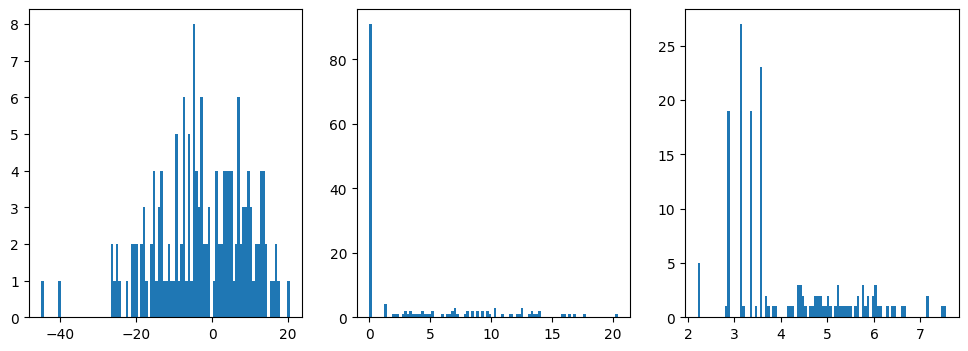

In [96]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist((output1).detach().numpy().flatten(), bins=100)

plt.subplot(1, 3, 2)
plt.hist((output2).detach().numpy().flatten(), bins=100)

plt.subplot(1, 3, 3)
plt.hist((output3).detach().numpy().flatten(), bins=100)
